<a href="https://colab.research.google.com/github/nilabja10201992/Cryptocurrency-Price-Prediction/blob/master/performance_on_various_crytocurrency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Library for Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [0]:
def mean_absolute_scaled_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    dem = 0
    num = 0
    for i in range(n-1):
        dem += y_true[i+1] - y_true[i]
    for i in range(n):
        num = abs(y_pred[i] - y_true[i])
        num = np.squeeze(num)
        res += num/dem
    res = np.squeeze(res)
    #print(num, dem, res)
    return res/n

In [0]:
def systematic_mean_absolute_percentage_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    for i in range(n):
        num = np.abs(y_pred[i] - y_true[i])
        dem = (np.abs(y_true[i]) + np.abs(y_pred[i]))/2
        res += num/dem
    res = np.squeeze(res)
    return 100*(res/n)

In [0]:
def extract_data(str):
    url = "https://coinmarketcap.com/currencies/"+ str+"/historical-data/?start=20130501&end=20190430"
    content = requests.get(url).content
    soup = BeautifulSoup(content,'html.parser')
    table = soup.find('table', {'class': 'table'})
    data = [[td.text.strip() for td in tr.findChildren('td')] 
            for tr in table.findChildren('tr')]
    df = pd.DataFrame(data)
    df.drop(df.index[0], inplace=True) # first row is empty
    df[0] =  pd.to_datetime(df[0]) # date
    for i in range(1,7):
        df[i] = pd.to_numeric(df[i].str.replace(",","").str.replace("-","")) # some vol is missing and has -
    df.columns = ['Date','Open','High','Low','Close','Volume','Market Cap']
    df.set_index('Date',inplace=True)
    df.sort_index(inplace=True)
    df.to_csv(str+'.csv', encoding='utf-8', index=False)

In [0]:
def scale_data(a):
    weighted_price = np.array(a.iloc[:,[0, 1,2,3, 5]])
    sclow = MinMaxScaler()
    low_price = np.array(a.iloc[:,[3]])
    low_priceSC = sclow.fit_transform(low_price)
    sc = MinMaxScaler()
    weighted_priceSC = sc.fit_transform(weighted_price)
    return sclow, sc, low_priceSC, weighted_priceSC

In [0]:
def func(wp, lp, timestep):
    timestep = timestep
    X = []
    y = []
    for i in range(timestep, len(wp)):
        X.append(wp[i-timestep:i, :])
        y.append(lp[i])
    X, y = np.array(X), np.array(y)
    #print(X.shape, y.shape)
    tr_size = int(0.8*len(wp))
    X_train = X[:tr_size,:]
    X_test = X[tr_size:,:]
    
    y_train = y[:tr_size]
    y_test = y[tr_size:]
    %%time
    # The LSTM architecture
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],5)))
    regressor.add(Dropout(0.2))
    # Second LSTM layer
    regressor.add(LSTM(units=128, return_sequences=True))
    regressor.add(Dropout(0.2))
    # Third LSTM layer
    regressor.add(LSTM(units=256, return_sequences=True))
    regressor.add(Dropout(0.5))
    # Fourth LSTM layer
    regressor.add(LSTM(units=512))
    regressor.add(Dropout(0.5))
    # The output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_absolute_error')
    # Fitting to the training set
    history = regressor.fit(X_train, y_train, epochs=100, batch_size=512)
    #regressor.save('modelbigw_l'+str(idx)+'.h5')
    #regressor = tf.keras.models.load_model('modelw_l'+str(idx)+'.h5')
    y_pred = regressor.predict(X_test)
    plt.figure(figsize=(14,6))
    plt.plot(y_test)
    plt.plot(y_pred)
    plt.legend(["Y", "Prediction"])
    plt.xlabel("Timeframe")
    plt.ylabel("Price")
    return history, mean_absolute_error(y_test, y_pred), systematic_mean_absolute_percentage_error(y_test, y_pred), mean_absolute_scaled_error(y_test, y_pred)

In [0]:
#extract_data('bitcoin')
bitcoin_df = pd.read_csv('bitcoin.csv')
bitcoin_a = bitcoin_df.fillna(method="backfill")
bitcoin_a.tail()

,Open,High,Low,Close,Volume,Market Cap
2183,5399.37,5633.80,5389.41,5572.36,1.586731e+10,98417387004
2184,5571.51,5642.04,5418.26,5464.87,1.704803e+10,96530038144
2185,5466.52,5542.24,5181.34,5210.52,1.533028e+10,92046492864
2186,5210.30,5383.63,5177.37,5279.35,1.681211e+10,93272287960
2187,5279.47,5310.75,5233.64,5268.29,1.311127e+10,93086156556


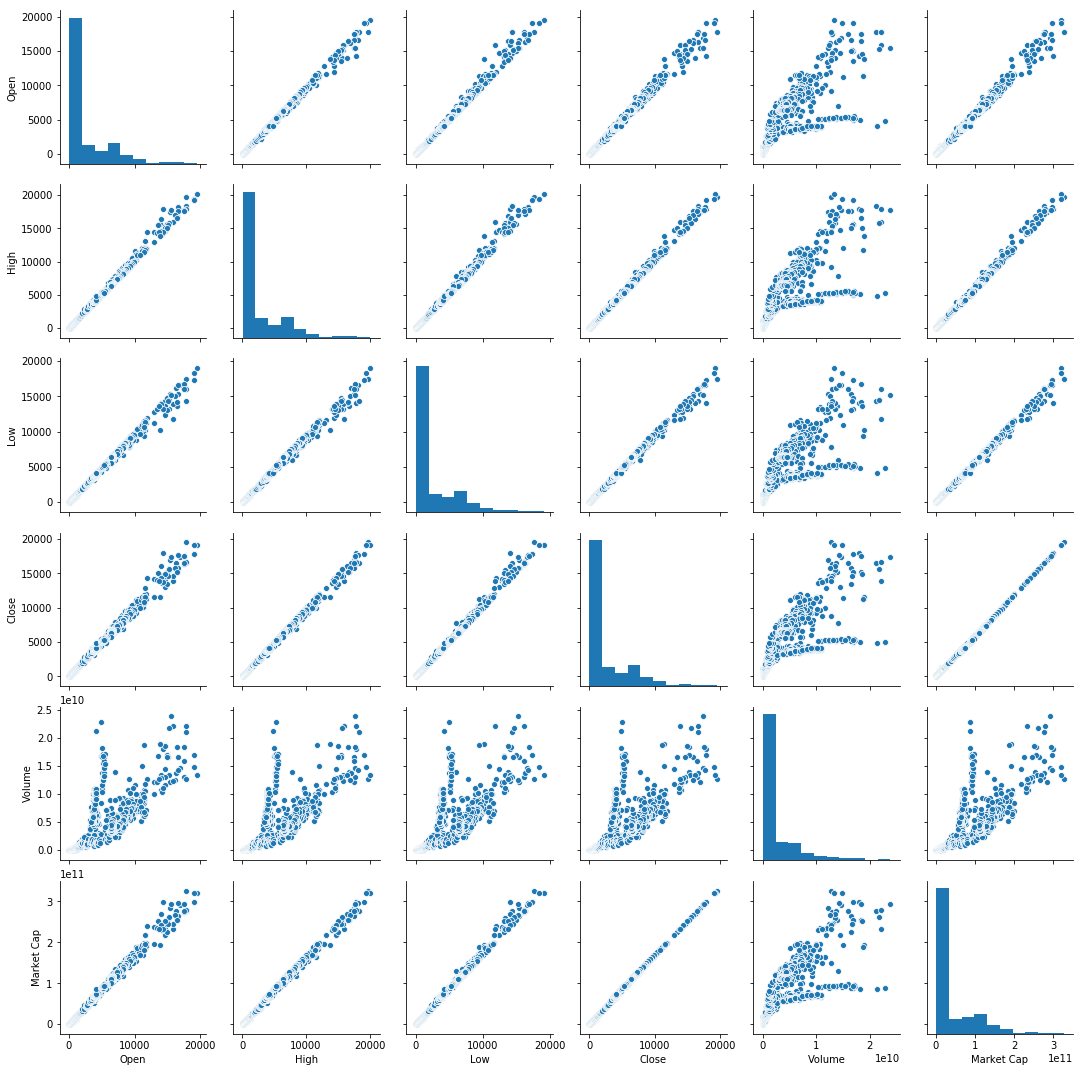

In [0]:
sns.pairplot(bitcoin_a)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1750/1750 [==============================] - 8s 5ms/step - loss: 0.0660
Epoch 2/100
1750/1750 [==============================] - 3s 1ms/step - loss: 0.0579
Epoch 3/100
1750/1750 [==============================] - 3s 1ms/step - loss: 0.0314
Epoch 4/100
1750/1750 [==============================] - 3s 1ms/step - loss: 0.0238
Epoch 5/100
1750/1750 [==============================] - 3s 1ms/step - loss: 0.0197
Epoch 6/100
1750/1750 [==============================] - 3s 1ms/step - loss: 0.0195
Epoch 7/100
1750/1750 [==============================] - 3s 1ms/step - loss: 0.0174
Epoch 8/100
1750/1750 [==============================] - 3s 1ms/step - loss: 0.0155
Epoch 9/100
1750/1750 [======

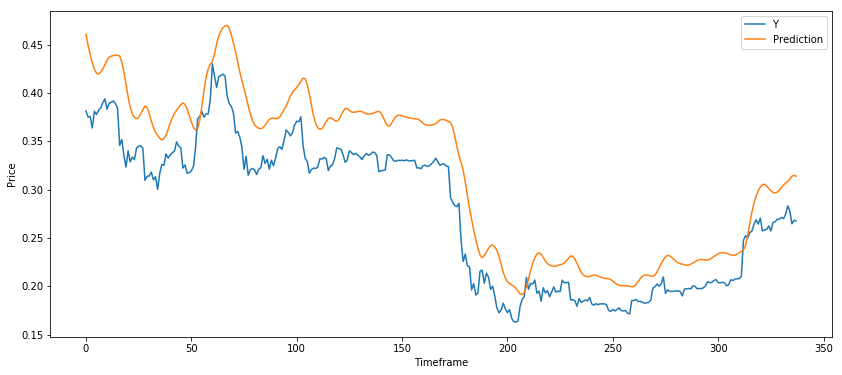

In [0]:
lsc, wsc, lp, wp = scale_data(bitcoin_a)
res = func(wp, lp, 100)

In [0]:
err_bitcoin = res[1:]

In [0]:
#extract_data('ripple')
ripple_df = pd.read_csv('ripple.csv')
ripple_a = ripple_df.fillna(method="backfill")
ripple_a.head()

,Open,High,Low,Close,Volume,Market Cap
0,0.005874,0.005927,0.005874,0.005882,148422.0,45983577
1,0.005875,0.005980,0.005613,0.005613,148422.0,43879157
2,0.005637,0.005661,0.004629,0.004680,148422.0,36591008
3,0.004669,0.004682,0.004333,0.004417,148422.0,34534121
4,0.004397,0.004424,0.004175,0.004254,148422.0,33258632


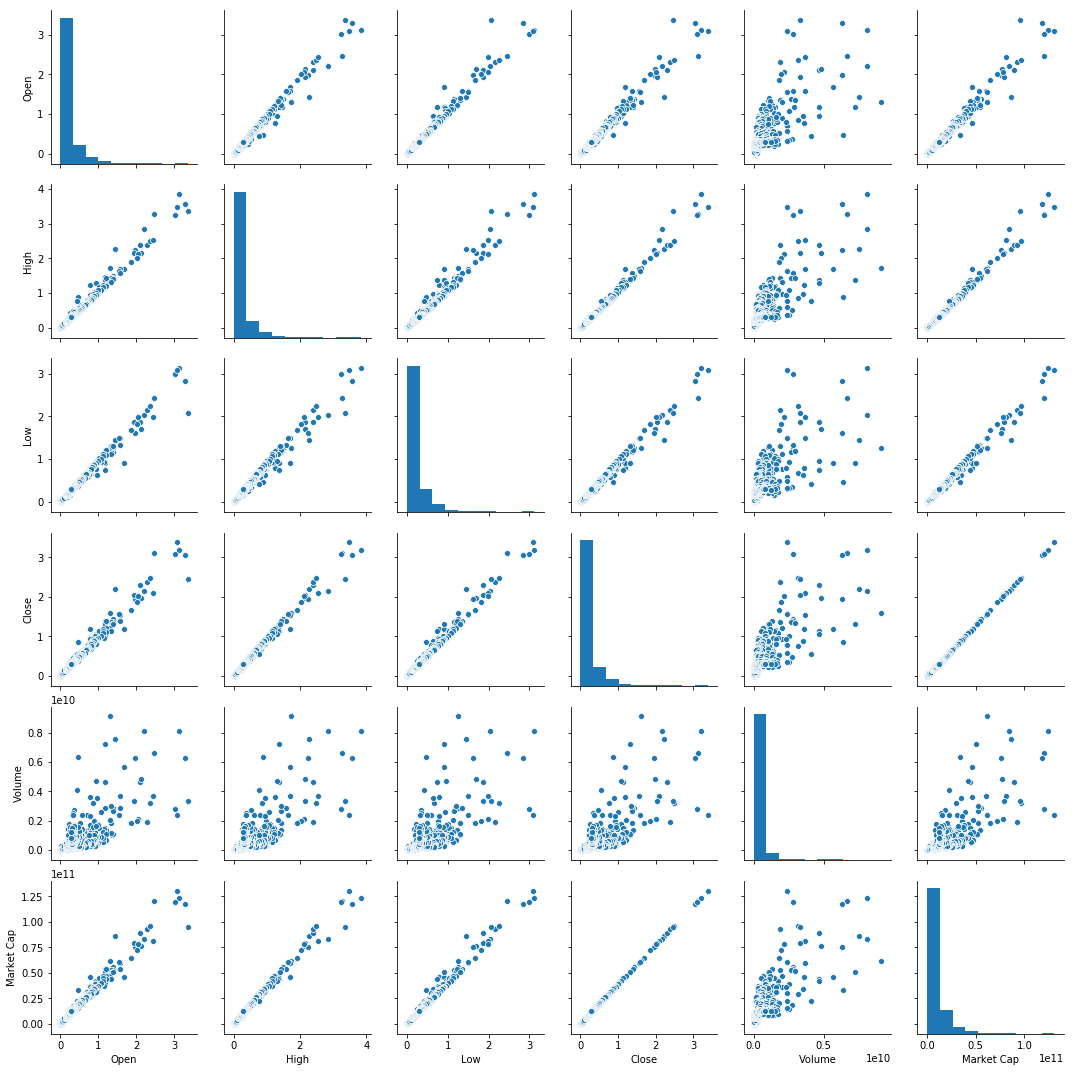

In [0]:
sns.pairplot(ripple_a)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs
Epoch 1/100
1674/1674 [==============================] - 6s 4ms/step - loss: 0.0380
Epoch 2/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0240
Epoch 3/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0170
Epoch 4/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0152
Epoch 5/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0151
Epoch 6/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0152
Epoch 7/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0136
Epoch 8/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0130
Epoch 9/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0118
Epoch 10/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0105
Epoch 11/100
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0108
Epoch 12/1

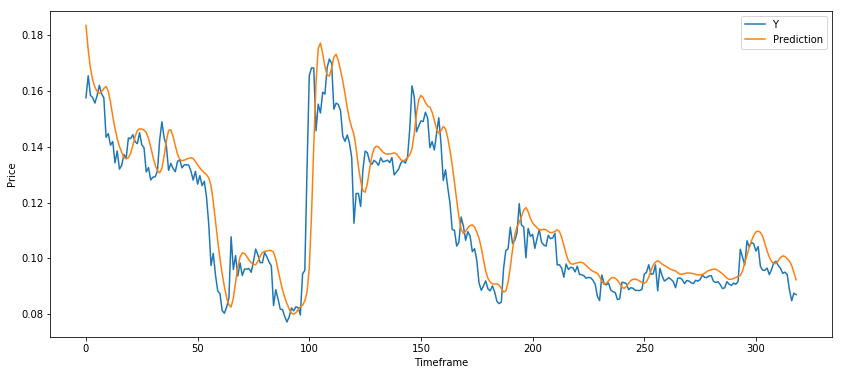

In [0]:
lsc, wsc, lp, wp = scale_data(ripple_a)
res = func(wp, lp, 100)

In [0]:
err_ripple = res[1:]

In [0]:
#extract_data('ethereum')
ethereum_df = pd.read_csv('ethereum.csv')
ethereum_a = ethereum_df.fillna(method="backfill")
ethereum_a.head()

,Open,High,Low,Close,Volume,Market Cap
0,2.830000,3.540000,2.520000,2.770000,164329,166610555
1,2.790000,2.800000,0.714725,0.753325,674188,45486894
2,0.706136,0.879810,0.629191,0.701897,532170,42399573
3,0.713989,0.729854,0.636546,0.708448,405283,42818364
4,0.708087,1.130000,0.663235,1.070000,1463100,64569288


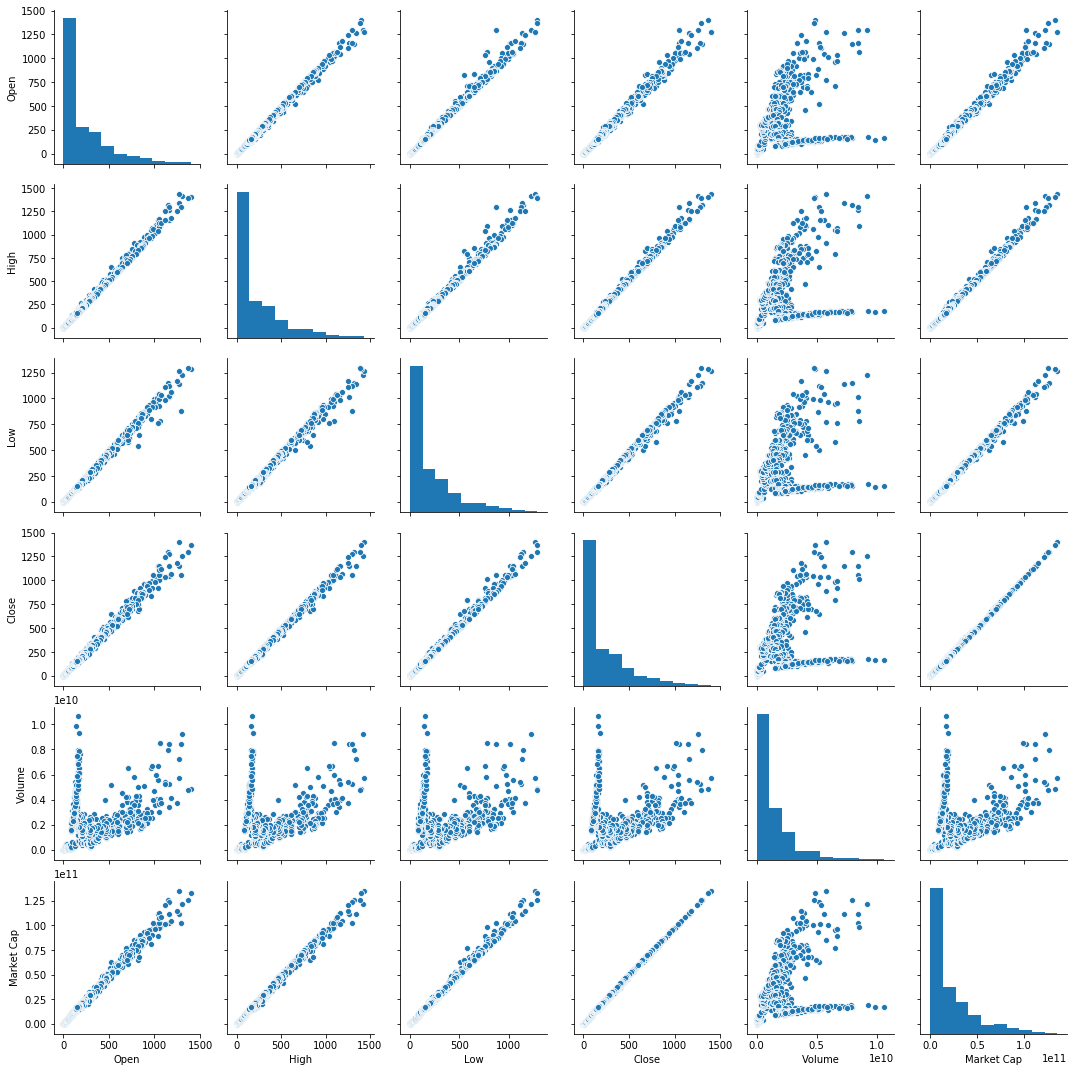

In [0]:
sns.pairplot(ethereum_a)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs
Epoch 1/100
1088/1088 [==============================] - 6s 6ms/step - loss: 0.1306
Epoch 2/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.0742
Epoch 3/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.1171
Epoch 4/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.0772
Epoch 5/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.0518
Epoch 6/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.0533
Epoch 7/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.0356
Epoch 8/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.0379
Epoch 9/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.0321
Epoch 10/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.0341
Epoch 11/100
1088/1088 [==============================] - 2s 2ms/step - loss: 0.0325
Epoch 12/1

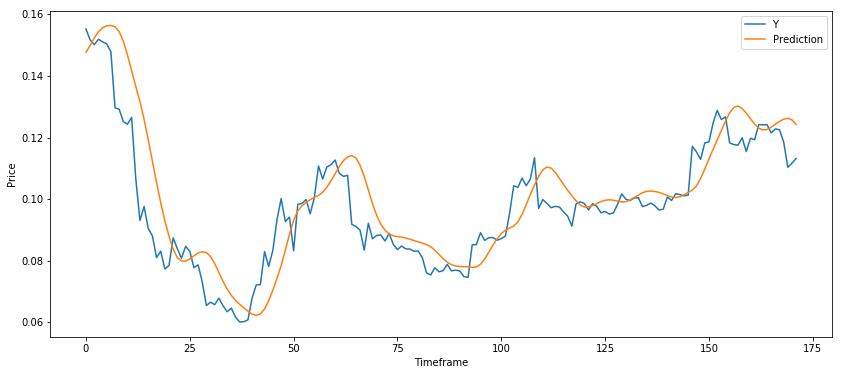

In [0]:
lsc, wsc, lp, wp = scale_data(ethereum_a)
res = func(wp, lp, 100)

In [0]:
err_ethereum = res[1:]

In [0]:
#extract_data('eos')
eos_df = pd.read_csv('eos.csv')
eos_a = eos_df.fillna(method="backfill")
eos_a.head()

,Open,High,Low,Close,Volume,Market Cap
0,1.030000,1.07,0.989566,1.01,13613000,654930711.0
1,0.996521,2.88,0.822648,2.71,320452000,654930711.0
2,2.720000,5.40,2.630000,4.09,414950016,654930711.0
3,4.100000,4.19,2.930000,3.37,218559008,550155157.0
4,3.360000,3.52,2.730000,3.00,124339000,500626422.0


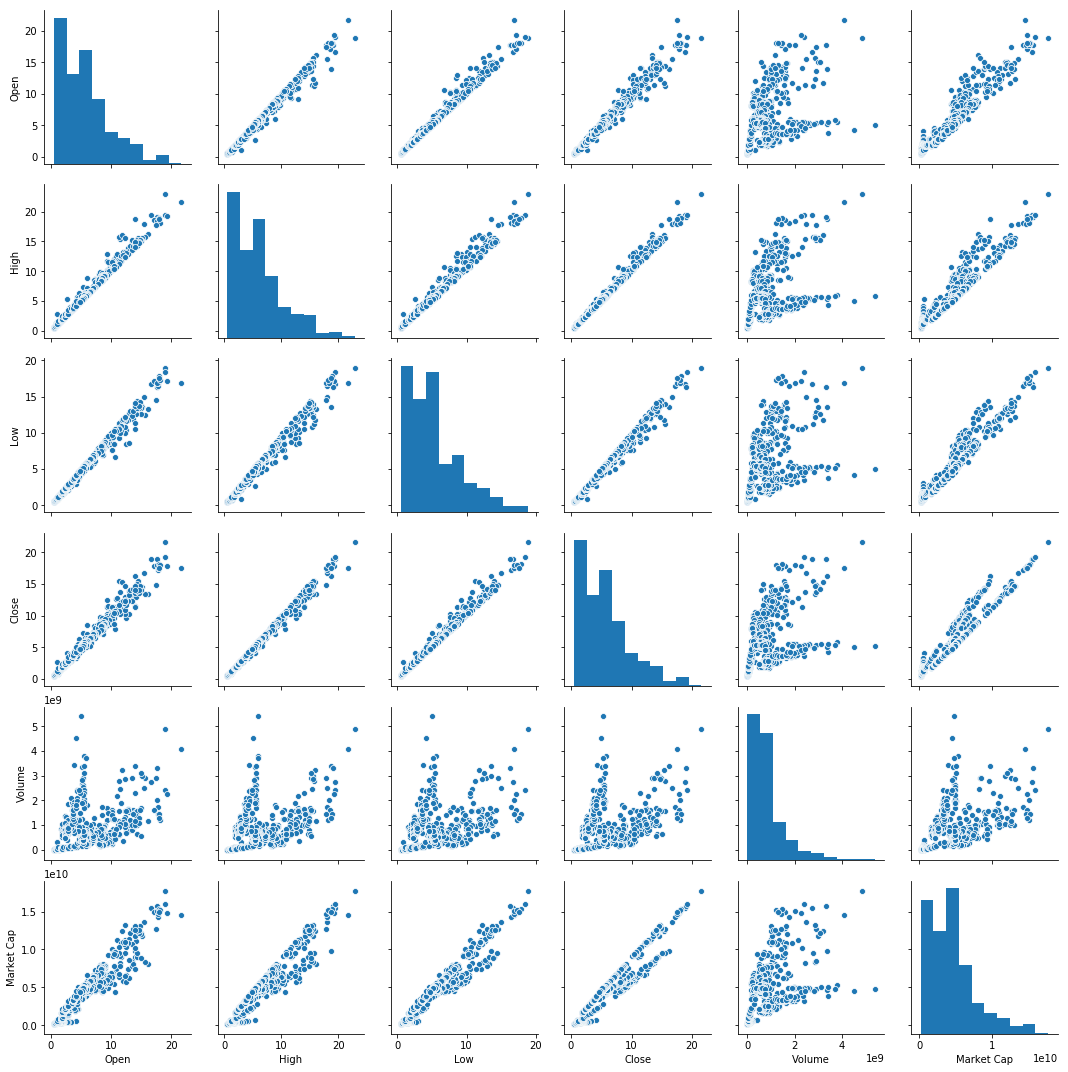

In [0]:
sns.pairplot(eos_a)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.54 µs
Epoch 1/100
532/532 [==============================] - 6s 12ms/step - loss: 0.2770
Epoch 2/100
532/532 [==============================] - 1s 2ms/step - loss: 0.3054
Epoch 3/100
532/532 [==============================] - 1s 2ms/step - loss: 0.1457
Epoch 4/100
532/532 [==============================] - 1s 2ms/step - loss: 0.1364
Epoch 5/100
532/532 [==============================] - 1s 2ms/step - loss: 0.0851
Epoch 6/100
532/532 [==============================] - 1s 2ms/step - loss: 0.0947
Epoch 7/100
532/532 [==============================] - 1s 2ms/step - loss: 0.1029
Epoch 8/100
532/532 [==============================] - 1s 2ms/step - loss: 0.1179
Epoch 9/100
532/532 [==============================] - 1s 2ms/step - loss: 0.0855
Epoch 10/100
532/532 [==============================] - 1s 2ms/step - loss: 0.0801
Epoch 11/100
532/532 [==============================] - 1s 2ms/step - loss: 0.0716
Epoch 12/100
532/532 [=====

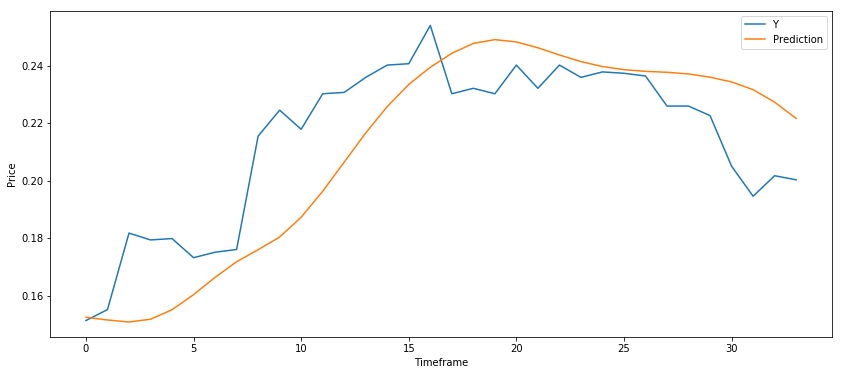

In [0]:
lsc, wsc, lp, wp = scale_data(eos_a)
#print(wp)
res = func(wp, lp, 100)

In [0]:
err_eos = res[1:]

In [0]:
#extract_data('litecoin')
litecoin_df = pd.read_csv('litecoin.csv')
litecoin_a = litecoin_df.fillna(method="backfill")
ripple_a.head()

,Open,High,Low,Close,Volume,Market Cap
0,0.005874,0.005927,0.005874,0.005882,148422.0,45983577
1,0.005875,0.005980,0.005613,0.005613,148422.0,43879157
2,0.005637,0.005661,0.004629,0.004680,148422.0,36591008
3,0.004669,0.004682,0.004333,0.004417,148422.0,34534121
4,0.004397,0.004424,0.004175,0.004254,148422.0,33258632


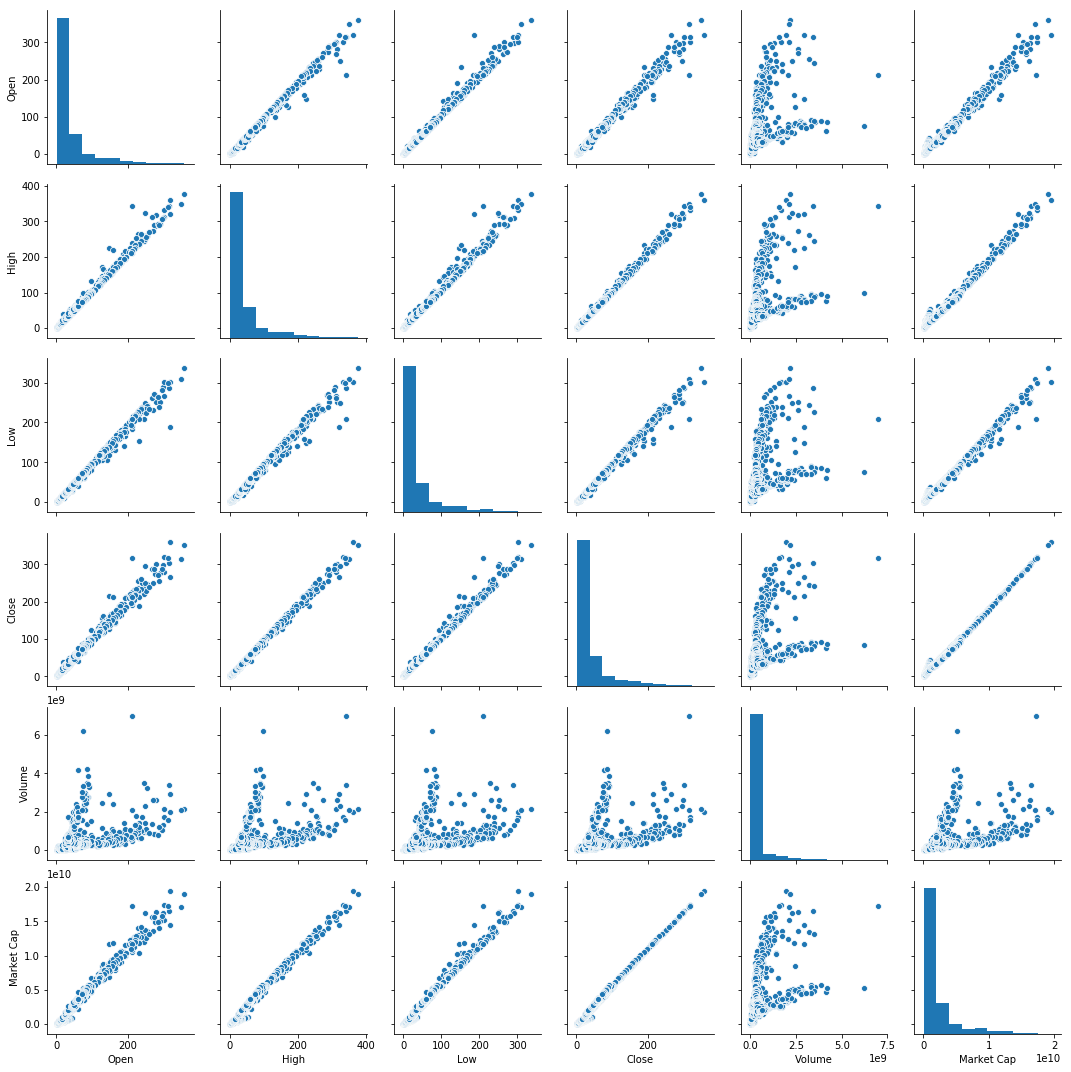

In [0]:
sns.pairplot(litecoin_a)

2188
CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.2 µs
Epoch 1/100
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0600
Epoch 2/100
1750/1750 [==============================] - 3s 1ms/step - loss: 0.0491
Epoch 3/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0278
Epoch 4/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0220
Epoch 5/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0202
Epoch 6/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0186
Epoch 7/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0183
Epoch 8/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0178
Epoch 9/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0162
Epoch 10/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0155
Epoch 11/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0155
E

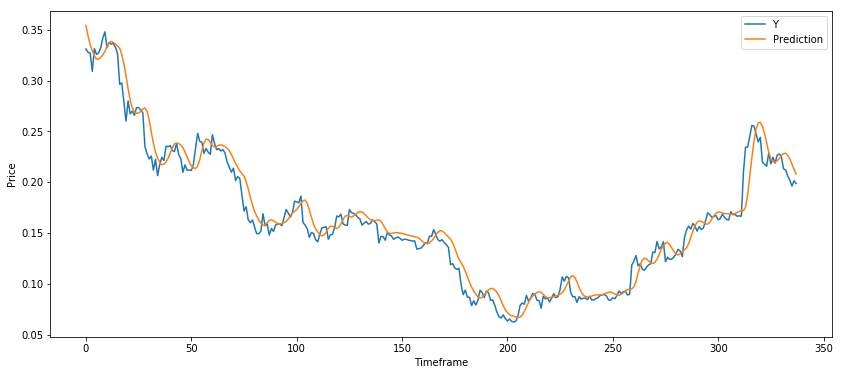

In [0]:
lsc, wsc, lp, wp = scale_data(litecoin_a)
print(len(wp))
res = func(wp, lp, 100)

In [0]:
err_litecoin = res[1:]

In [0]:
#extract_data('binance-coin')
binance_coin_df = pd.read_csv('binance-coin.csv')
binance_coin_a = binance_coin_df.fillna(method="backfill")
binance_coin_a.head()

,Open,High,Low,Close,Volume,Market Cap
0,0.115203,0.115841,0.101531,0.105870,145269,10587000
1,0.105893,0.109013,0.099266,0.105138,200395,10513800
2,0.105108,0.108479,0.100888,0.107737,344499,10773700
3,0.107632,0.109019,0.101473,0.104067,342568,10406700
4,0.104782,0.111264,0.101108,0.107811,340218,10781100


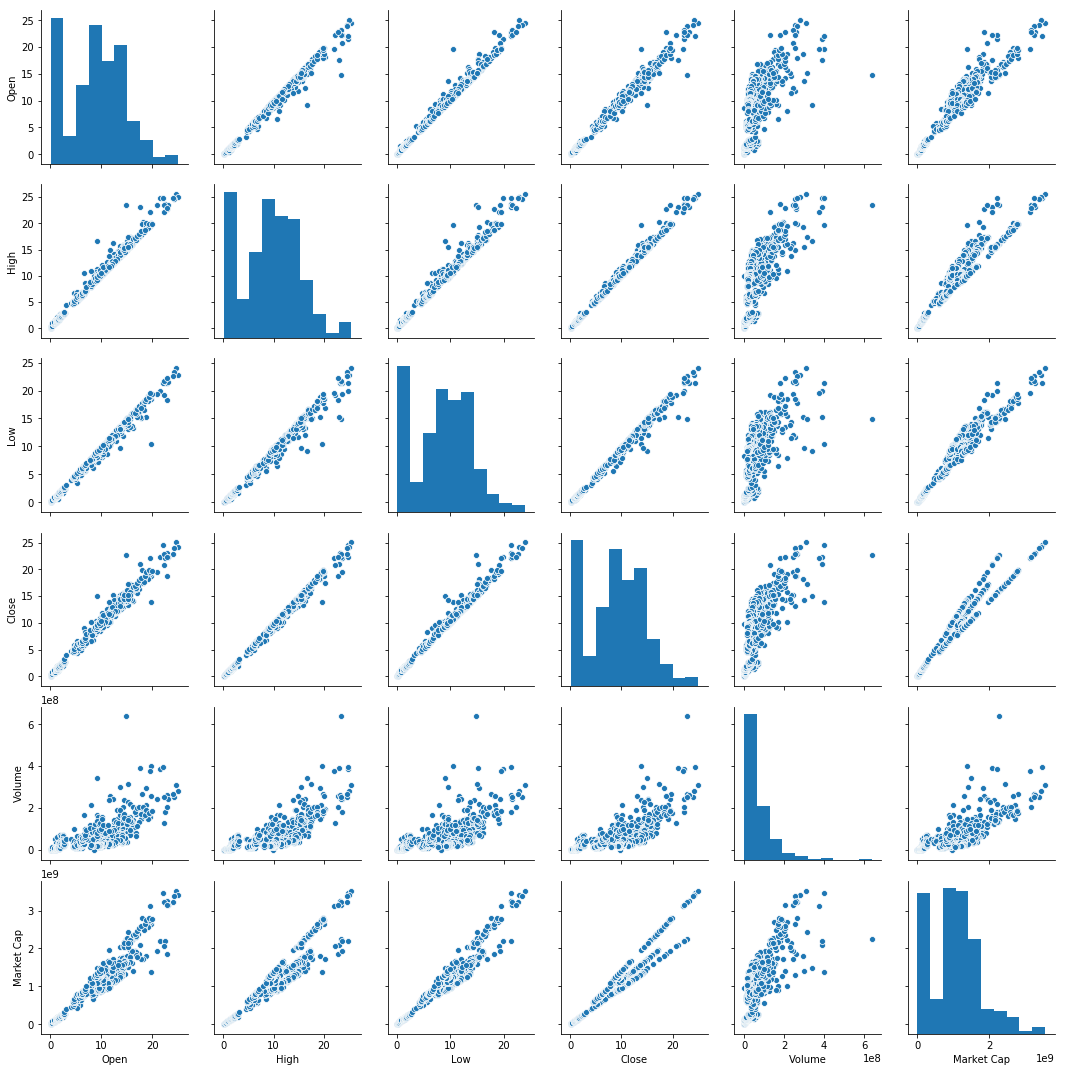

In [0]:
sns.pairplot(binance_coin_a)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.58 µs
Epoch 1/100
513/513 [==============================] - 9s 17ms/step - loss: 0.3967
Epoch 2/100
513/513 [==============================] - 1s 3ms/step - loss: 0.2311
Epoch 3/100
513/513 [==============================] - 1s 3ms/step - loss: 0.1820
Epoch 4/100
513/513 [==============================] - 1s 2ms/step - loss: 0.1256
Epoch 5/100
513/513 [==============================] - 1s 2ms/step - loss: 0.0794
Epoch 6/100
513/513 [==============================] - 1s 2ms/step - loss: 0.2022
Epoch 7/100
513/513 [==============================] - 1s 2ms/step - loss: 0.0980
Epoch 8/100
513/513 [==============================] - 1s 2ms/step - loss: 0.1175
Epoch 9/100
513/513 [==============================] - 1s 2ms/step - loss: 0.0753
Epoch 10/100
513/513 [==============================] - 1s 2ms/step - loss: 0.1416
Epoch 11/100
513/513 [==============================] - 1s 3ms/step - loss: 0.1031
Epoch 12/100
513/513 [=====

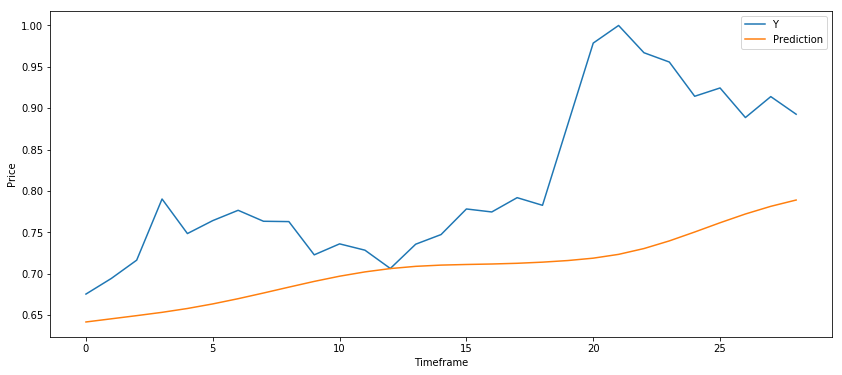

In [0]:
lsc, wsc, lp, wp = scale_data(binance_coin_a)
res = func(wp, lp, 100)

In [0]:
err_binance = res[1:]

In [0]:
#extract_data('tether')
ether_df = pd.read_csv('tether.csv')
ether_a = ether_df.fillna(method="backfill")
ether_a.head()

,Open,High,Low,Close,Volume,Market Cap
0,1.210000,1.220000,1.210000,1.210000,6,304713
1,1.210000,1.210000,1.190000,1.210000,6,303364
2,0.571249,0.607890,0.568314,0.606502,3,152596
3,0.605129,0.606229,0.604416,0.606229,3,152527
4,1.000000,1.000000,1.000000,1.000000,93,251600


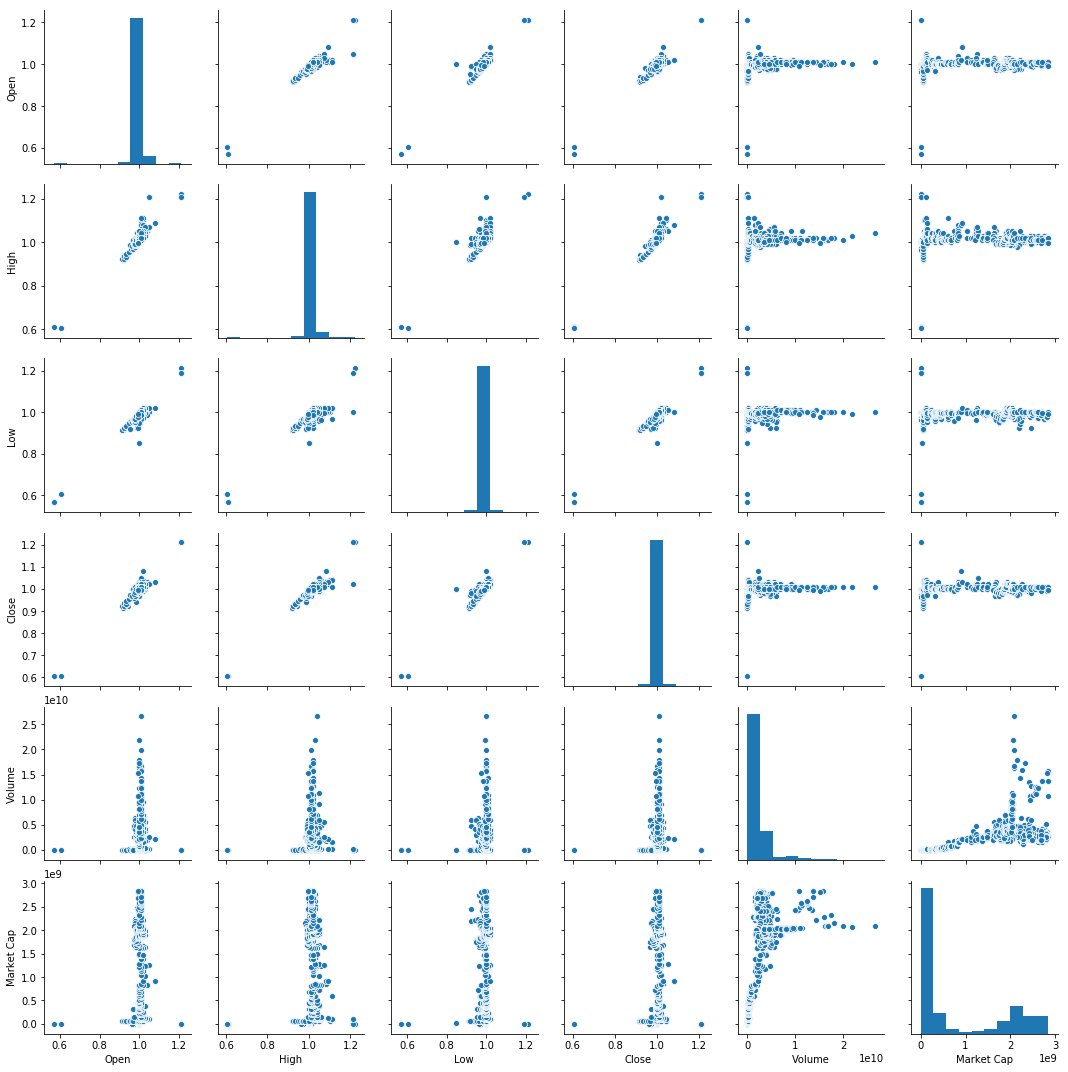

In [0]:
sns.pairplot(ether_a)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
Epoch 1/100
1214/1214 [==============================] - 10s 8ms/step - loss: 0.5456
Epoch 2/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.2213
Epoch 3/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.3806
Epoch 4/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.1474
Epoch 5/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.0810
Epoch 6/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.0686
Epoch 7/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.0548
Epoch 8/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.0494
Epoch 9/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.0464
Epoch 10/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.0419
Epoch 11/100
1214/1214 [==============================] - 2s 2ms/step - loss: 0.0424
Epoch 12/

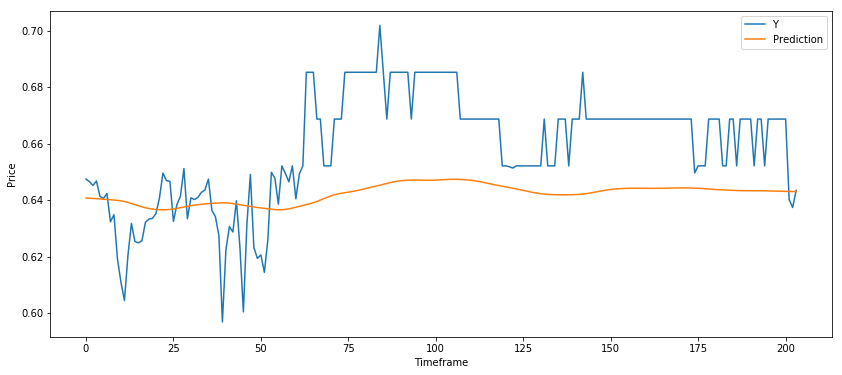

In [0]:
lsc, wsc, lp, wp = scale_data(ether_a)
res = func(wp, lp, 100)

In [0]:
err_ether = res[1:]

In [0]:
#extract_data('stellar')
stellar_df = pd.read_csv('stellar.csv')
stellar_a = stellar_df.fillna(method="backfill")
stellar_a.head()

,Open,High,Low,Close,Volume,Market Cap
0,0.002976,0.003387,0.002349,0.002440,30316,767679
1,0.002373,0.003402,0.002266,0.002657,35820,966370
2,0.002686,0.003042,0.002455,0.002501,142864,1079148
3,0.002493,0.003243,0.002493,0.002881,93708,1260109
4,0.002884,0.003710,0.002873,0.003481,233579,1645185


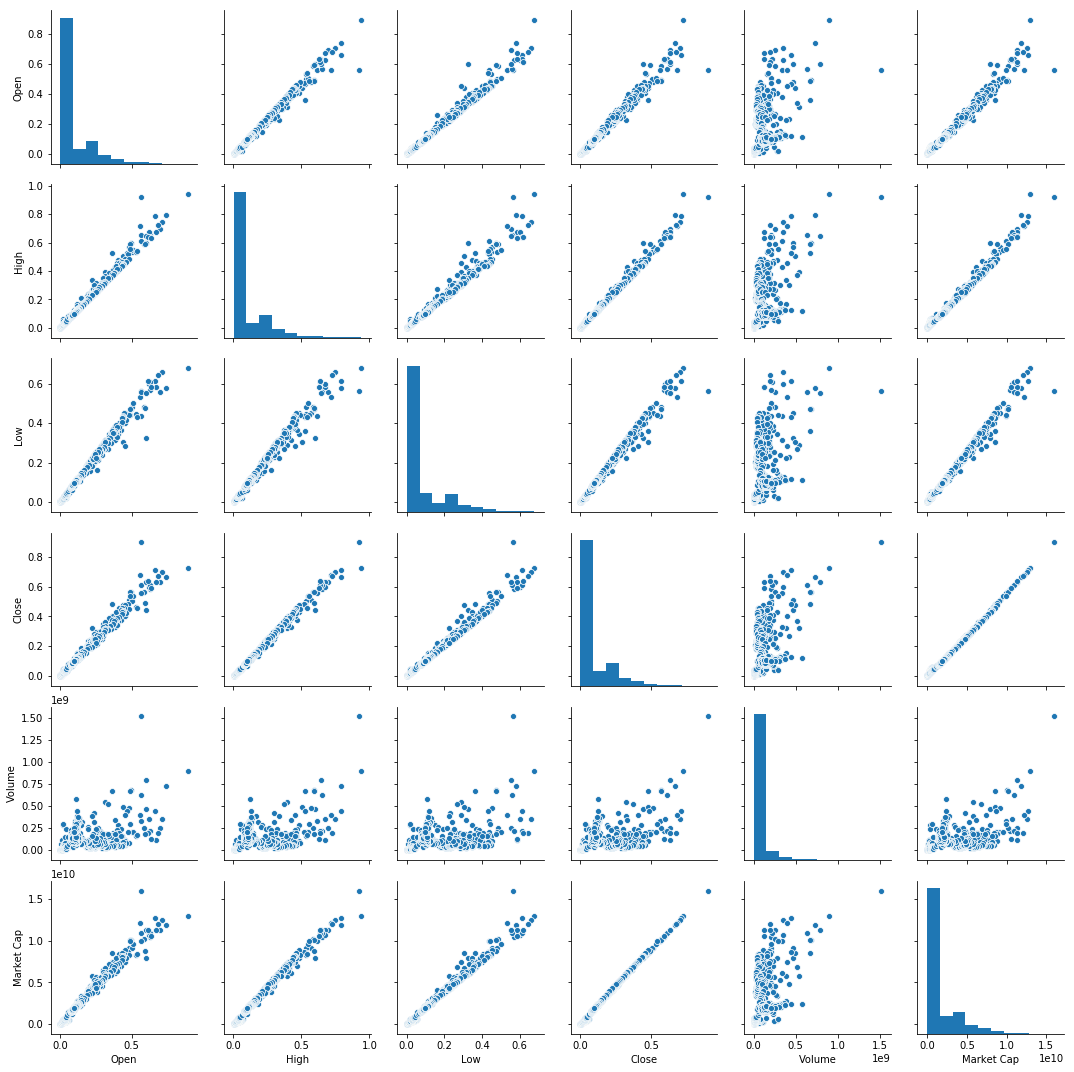

In [0]:
sns.pairplot(stellar_a)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
Epoch 1/100
1381/1381 [==============================] - 11s 8ms/step - loss: 0.0635
Epoch 2/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0549
Epoch 3/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0267
Epoch 4/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0246
Epoch 5/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0222
Epoch 6/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0199
Epoch 7/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0189
Epoch 8/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0172
Epoch 9/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0186
Epoch 10/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0160
Epoch 11/100
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0156
Epoch 12/

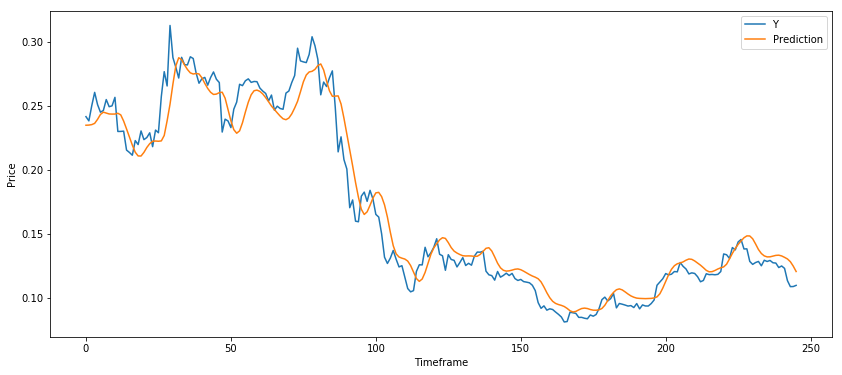

In [0]:
lsc, wsc, lp, wp = scale_data(stellar_a)
res = func(wp, lp, 100)

In [0]:
err_stellar = res[1:]

In [0]:
#extract_data('cardano')
cardano_df = pd.read_csv('cardano.csv')
cardano_a = cardano_df.fillna(method="backfill")
cardano_a.head()

,Open,High,Low,Close,Volume,Market Cap
0,0.021678,0.032226,0.017354,0.024969,50068700,628899052.0
1,0.024607,0.030088,0.019969,0.025932,57641300,628899052.0
2,0.025757,0.027425,0.020690,0.020816,16997800,539692715.0
3,0.020864,0.022806,0.020864,0.021931,9000050,568619548.0
4,0.021951,0.022154,0.020859,0.021489,5562510,557139041.0


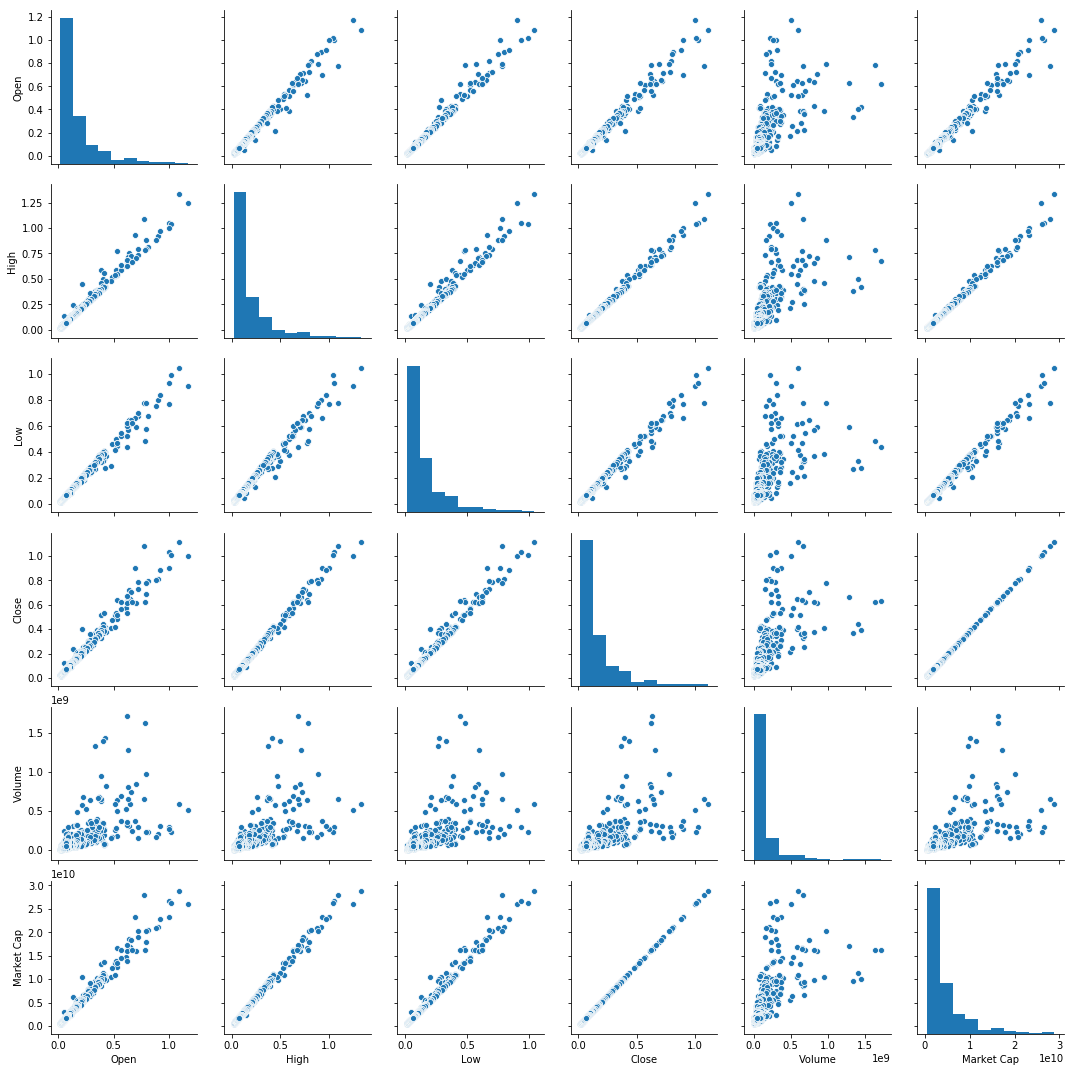

In [0]:
sns.pairplot(cardano_a)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.7 µs
Epoch 1/100
459/459 [==============================] - 10s 22ms/step - loss: 0.1325
Epoch 2/100
459/459 [==============================] - 1s 1ms/step - loss: 0.0413
Epoch 3/100
459/459 [==============================] - 1s 2ms/step - loss: 0.1761
Epoch 4/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0445
Epoch 5/100
459/459 [==============================] - 1s 1ms/step - loss: 0.0714
Epoch 6/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0624
Epoch 7/100
459/459 [==============================] - 1s 1ms/step - loss: 0.0420
Epoch 8/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0400
Epoch 9/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0521
Epoch 10/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0411
Epoch 11/100
459/459 [==============================] - 1s 1ms/step - loss: 0.0322
Epoch 12/100
459/459 [====

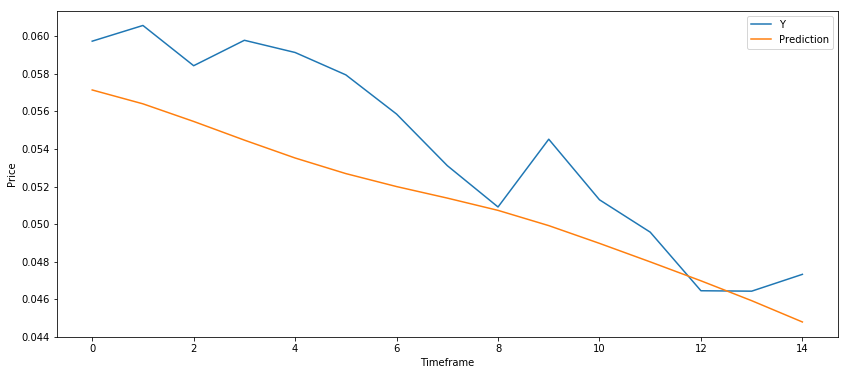

In [0]:
lsc, wsc, lp, wp = scale_data(cardano_a)
res = func(wp, lp, 100)

In [0]:
err_cardano = res[1:]

In [0]:
extract_data('bitcoin-cash')
bitcoin_cash_df = pd.read_csv('bitcoin-cash.csv')
bitcoin_cash_a = cardano_df.fillna(method="backfill")
bitcoin_cash_a.head()

,Open,High,Low,Close,Volume,Market Cap
0,0.021678,0.032226,0.017354,0.024969,50068700,628899052.0
1,0.024607,0.030088,0.019969,0.025932,57641300,628899052.0
2,0.025757,0.027425,0.020690,0.020816,16997800,539692715.0
3,0.020864,0.022806,0.020864,0.021931,9000050,568619548.0
4,0.021951,0.022154,0.020859,0.021489,5562510,557139041.0


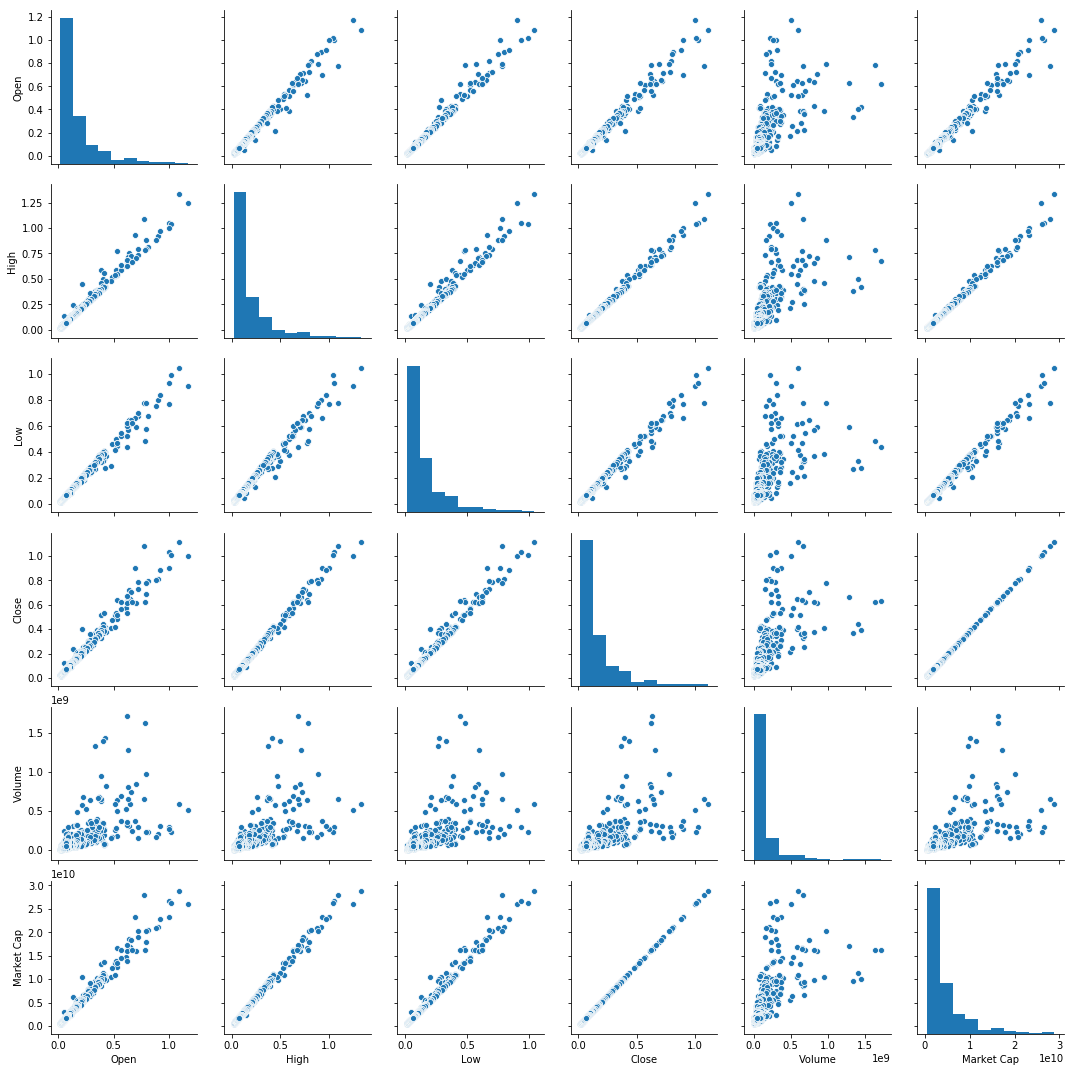

In [0]:
sns.pairplot(bitcoin_cash_a)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs
Epoch 1/100
459/459 [==============================] - 11s 24ms/step - loss: 0.1304
Epoch 2/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0472
Epoch 3/100
459/459 [==============================] - 1s 2ms/step - loss: 0.2138
Epoch 4/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0309
Epoch 5/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0748
Epoch 6/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0741
Epoch 7/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0590
Epoch 8/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0448
Epoch 9/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0451
Epoch 10/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0557
Epoch 11/100
459/459 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 12/100
459/459 [========

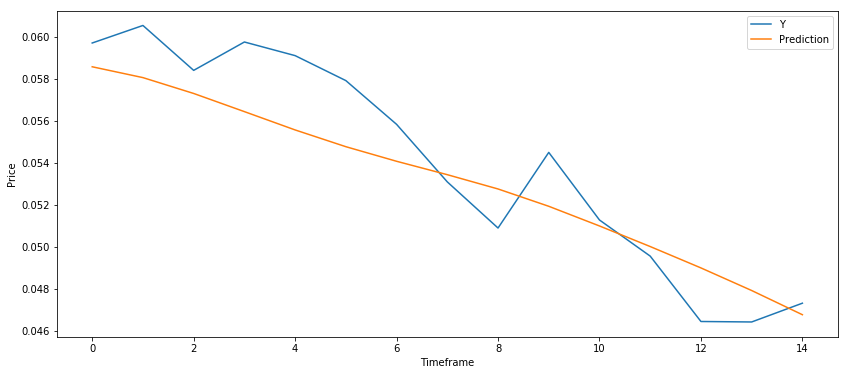

In [0]:
lsc, wsc, lp, wp = scale_data(bitcoin_cash_a)
res = func(wp, lp, 100)

In [0]:
err_bitcoin_cash = res[1:]

In [0]:
def func(err, str):
  print('Cryptocurrency: '+ str)
  print("Mean absolute error {0}\nSystematic mean absolute percentage error {1} \nMean_absolute_scaled_error {2}".format(err[0], err[1], err[2]))

In [0]:
func(err_bitcoin, 'bitcoin')

Cryptocurrency: bitcoin
Mean absolute error 0.03949681396804048
Systematic mean absolute percentage error 13.455421688133857 
Mean_absolute_scaled_error -0.34694143530557664


In [0]:
func(err_ethereum, 'Ethereum')

Cryptocurrency: Ethereum
Mean absolute error 0.007689227087451871
Systematic mean absolute percentage error 7.840076151631892 
Mean_absolute_scaled_error -0.18270718281760545


In [0]:
func(err_ripple, 'ripple')

Cryptocurrency: ripple
Mean absolute error 0.0071392951366548545
Systematic mean absolute percentage error 6.128841242735467 
Mean_absolute_scaled_error -0.10133890998965793


In [0]:
func(err_binance, 'binance')

Cryptocurrency: binance
Mean absolute error 0.10418223141482044
Systematic mean absolute percentage error 13.206893966898873 
Mean_absolute_scaled_error 0.47970300199259813


In [0]:
func(err_litecoin, 'liteoin')

Cryptocurrency: liteoin
Mean absolute error 0.010014935759157361
Systematic mean absolute percentage error 6.477751067199486 
Mean_absolute_scaled_error -0.07559456370363114


In [0]:
func(err_eos, 'EOS')

Cryptocurrency: EOS
Mean absolute error 0.01693552163386849
Systematic mean absolute percentage error 8.23013192744696 
Mean_absolute_scaled_error 0.3460564207142354


In [0]:
func(err_ether, 'Tether')

Cryptocurrency: Tether
Mean absolute error 0.020523244979928263
Systematic mean absolute percentage error 3.132960838434452 
Mean_absolute_scaled_error -5.107724709306073


In [0]:
func(err_stellar, 'Stellar')

Cryptocurrency: Stellar
Mean absolute error 0.011039024634382959
Systematic mean absolute percentage error 6.739239148892286 
Mean_absolute_scaled_error -0.08382685562752684


In [0]:
func(err_cardano, 'Cardona')

Cryptocurrency: Cardona
Mean absolute error 0.0029148303820737123
Systematic mean absolute percentage error 5.381590070484745 
Mean_absolute_scaled_error -0.23505162051337677


In [0]:
func(err_bitcoin_cash, 'bitcoin_cash')

Cryptocurrency: bitcoin_cash
Mean absolute error 0.0017736687261088208
Systematic mean absolute percentage error 3.2605609209679116 
Mean_absolute_scaled_error -0.14302846261303725
